# Computational Neuroscience

## Lecture 1: Introduction

...

## Lecture 2: Hodgkin-Huxley model

Experimentally fitted to data recorded from the Giant Squid Axon.

$$
\sum_k I_k = g_{Na} m^3 h (u - E_{Na}) + g_k n^4 (u - E_K) + g_L (u - E_L) \\
\dot m = \alpha_m (u) \cdot (1-m) - \beta_m (u) \cdot m \\
\dot n = \alpha_n (u) \cdot (1-n) - \beta_n (u) \cdot n \\
\dot h = \alpha_h (u) \cdot (1-h) - \beta_h (u) \cdot h \\
$$

s.t. $k_{t+\Delta t} = k_t + \Delta t \cdot (\alpha_h (u) \cdot (1-h) - \beta_h (u) \cdot h)$

where

$$
C \frac{\text{d} u}{\text{d} t} = I(t) - \sum_k I_k(t) \tilde = C \frac{u_{t+\Delta t} - u_{t}}{\Delta t} \\
u_{t+\Delta t} = \frac{I(t) - \sum_k I_k(t)}{C} + u_t
$$

Probabilistic interpretation of $n$ and $m$ is the mean of the Bernoulli variable modeling each ion channel.

### Defintion of constants

Note the use of the fixed offset voltage of -65 mV. This may be set to 0 mV as well.

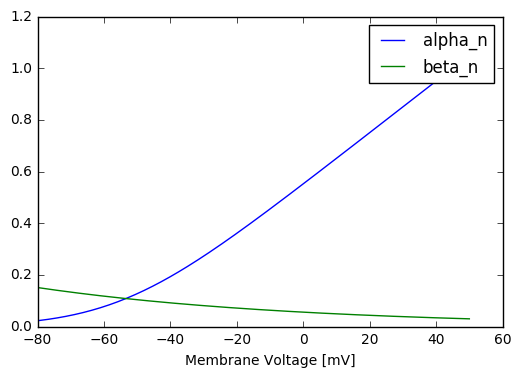

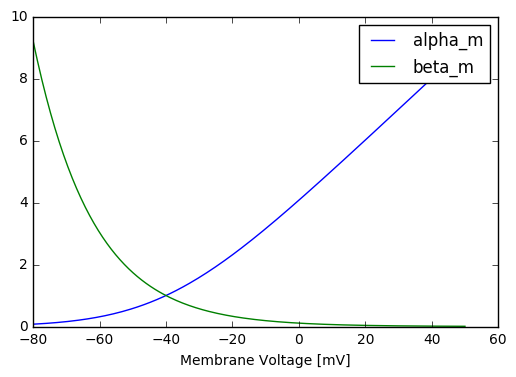

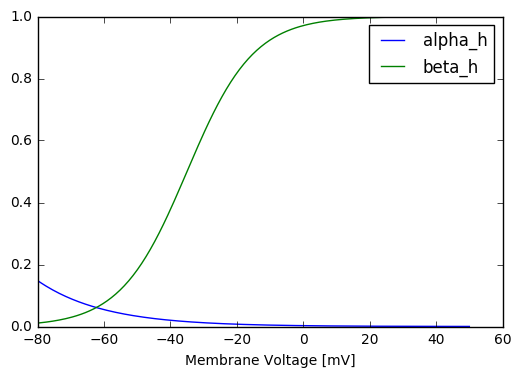

In [31]:
import numpy as np
from pylab import *
%matplotlib inline

# Offset voltage level
u_off = -65

# Sodium: m³ is probability, h gating variable
α_m = lambda u: (2.5 - 0.1*(u - u_off)) / (np.exp(2.5 - 0.1*(u - u_off)) - 1)
β_m  = lambda u : 4*np.exp(-(u - u_off)/18)
α_h = lambda u: 0.07 * np.exp(-(u - u_off)/20)
β_h  = lambda u : 1/(np.exp(3 - 0.1*(u - u_off))+1)
g_Na = 120
E_Na = 115 + u_off

# Potassium: n^4 is the probability
α_n = lambda u: (0.1 - 0.01*(u - u_off)) / (np.exp(1-0.1*(u - u_off))-1)
β_n  = lambda u : 0.125 * np.exp(-(u - u_off)/80)
g_K = 36
E_K = -12 + u_off

# Everything else is covered by E_L
g_L = 0.3
E_L = 10.6 + u_off

uu = np.linspace(-80, 50, 200)

plot(uu, α_n(uu), label="alpha_n")
plot(uu, β_n(uu), label="beta_n")
legend()
xlabel("Membrane Voltage [mV]")
show()

plot(uu, α_m(uu), label="alpha_m")
plot(uu, β_m(uu), label="beta_m")
legend()
xlabel("Membrane Voltage [mV]")
show()

plot(uu, α_h(uu), label="alpha_h")
plot(uu, β_h(uu), label="beta_h")
legend()
xlabel("Membrane Voltage [mV]")
show()

## Compute membrane voltage

In [32]:
ddt    = lambda alpha, beta, u, last : alpha(u) * (1 - last) - beta(u) * last
update = lambda alpha, beta, u, last, dt : ddt(alpha,  beta, u, last) * dt + last

def compute(I_in, dt=0.001):
    nb_samples, = I_in.shape
    
    u_t = np.zeros_like(I_in)
    I_out = np.zeros_like(I_in)
    nn = np.zeros_like(I_in)
    mm = np.zeros_like(I_in)
    hh = np.zeros_like(I_in)

    u = u_off

    n = ddt(α_n, β_n, u, 0)/(ddt(α_n, β_n, u, 0)-ddt(α_n, β_n, u, 1))
    m = ddt(α_m, β_m, u, 0)/(ddt(α_m, β_m, u, 0)-ddt(α_m, β_m, u, 1))
    h = ddt(α_h, β_h, u, 0)/(ddt(α_h, β_h, u, 0)-ddt(α_h, β_h, u, 1))
    
    print(n,m,h)
    
    u_t[0] = u
    C = 1
    
    for i in range(1, nb_samples):
        I = g_Na * m**3 * h * (u - E_Na) + g_K * n**4 * (u - E_K) + g_L * (u - E_L)
        
        n = update(α_n, β_n, u, n, dt)
        m = update(α_m, β_m, u, m, dt)
        h = update(α_h, β_h, u, h, dt)
        
        u = (I_in[i-1] - I_out[i-1]) / C * dt + u_t[i-1]
        
        nn[i], mm[i], hh[i], u_t[i], I_out[i] = n, m, h, u, I
    
    return u_t, I_out, nn, mm, hh

### First experiment: Pulses with increasing magnitude

0.317676914061 0.0529324852572 0.596120753508


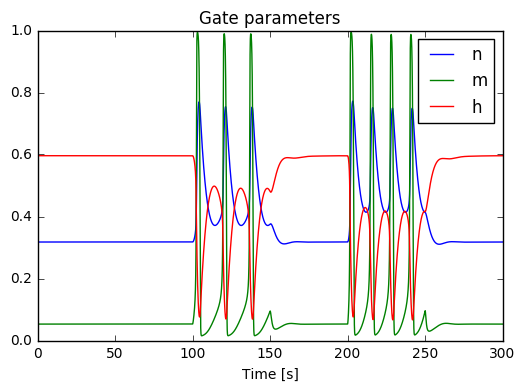

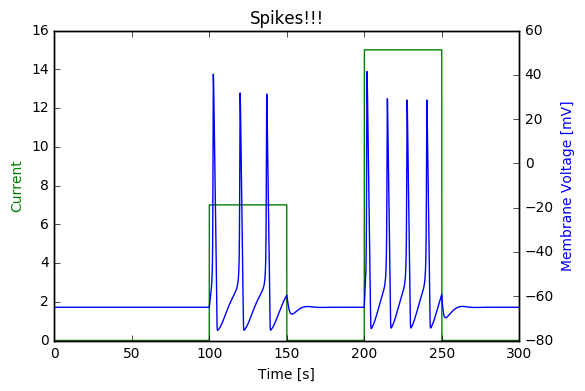

In [33]:
total_time = 300 #s
dt = 0.01
nb_samples = int(total_time / dt)

tt = np.linspace(0, total_time, nb_samples)
I_in = np.zeros((nb_samples,))
timeslice = lambda start, end : slice(int(start/dt), int(end/dt))

I_in[timeslice(100,150)] = 7
I_in[timeslice(200,250)] = 15

u, I_out, n, m, h = compute(I_in, dt)

# ----------- plotting ---------------- #

plot(tt, n, label="n")
plot(tt, m, label="m")
plot(tt, h, label="h")
xlabel("Time [s]")
legend()
title("Gate parameters")
show()

fig, ax1 = subplots()

ax2 = ax1.twinx()
ax1.plot(tt, I_in, 'g-')
ax2.plot(tt, u, 'b-')

ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Current', color='g')
ax2.set_ylabel('Membrane Voltage [mV]', color='b')
ax2.set_ylim([-80, 60])
title("Spikes!!!")
show()

0.317676914061 0.0529324852572 0.596120753508


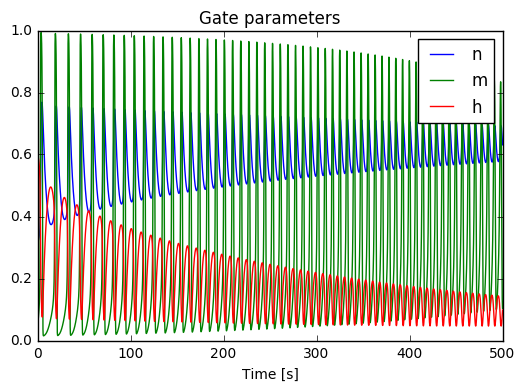

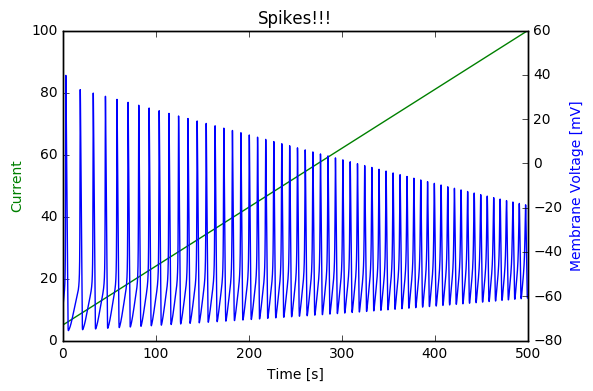

0.631210608039 0.103539248505 0.0982166930972


In [34]:
total_time = 500 #s
dt = 0.01
nb_samples = int(total_time / dt)

tt = np.linspace(0, total_time, nb_samples)
I_in = np.zeros((nb_samples,))
timeslice = lambda start, end : slice(int(start/dt), int(end/dt))

I_in = np.linspace(5, 100, nb_samples)
u, I_out, n, m, h = compute(I_in, dt)

# ----------- plotting ---------------- #

plot(tt, n, label="n")
plot(tt, m, label="m")
plot(tt, h, label="h")
xlabel("Time [s]")
legend()
title("Gate parameters")
show()

fig, ax1 = subplots()

ax2 = ax1.twinx()
ax1.plot(tt, I_in, 'g-')
ax2.plot(tt, u, 'b-')

ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Current', color='g')
ax2.set_ylabel('Membrane Voltage [mV]', color='b')
ax2.set_ylim([-80, 60])
title("Spikes!!!")
show()

print(n[-1],m[-1],h[-1])

# Compute spike frequency over time

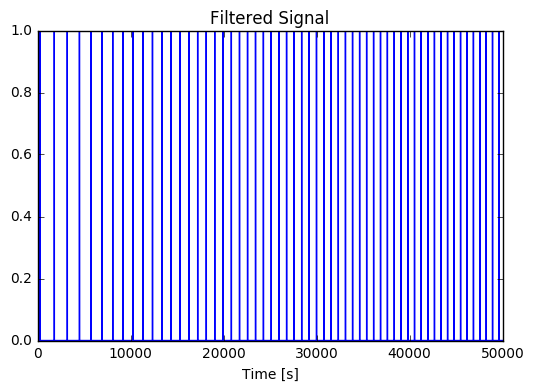

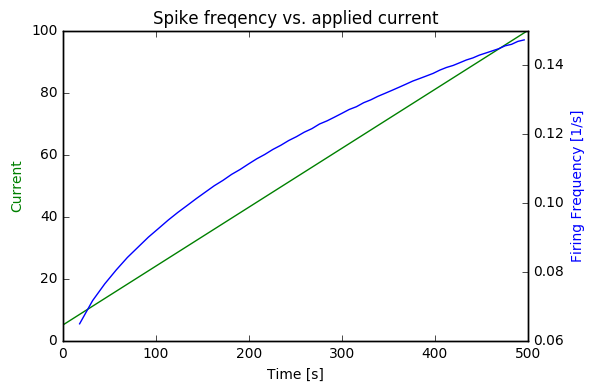

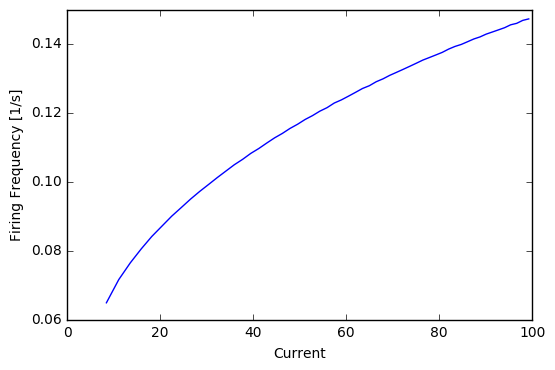

In [35]:
spikes = 1*(u > -45)
spikes = (spikes[1:] - spikes[0:-1]) > 0
dts = tt[1:][spikes]
ddts = dts[1:] - dts[0:-1]

plot(spikes)
title("Filtered Signal")
xlabel("Time [s]")
show()

fig, ax1 = subplots()

ax2 = ax1.twinx()
ax1.plot(tt, I_in, 'g-')
ax2.plot(dts[1:], 1/ddts, 'b-')

ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Current', color='g')
ax2.set_ylabel("Firing Frequency [1/s]", color="b")
title("Spike freqency vs. applied current")
show()

plot(I_in[1:][spikes][1:], 1/ddts)
xlabel("Current")
ylabel("Firing Frequency [1/s]")
show()